In [1]:
import qiskit
import numpy as np

In [2]:
def swap_qubits(qc, qreg):
    """
    Reverse the order of qubits
    Note: qiskit qubit order is most significant last (i.e. q[n-1])
    """
    for i in range(len(qreg)//2):
        qc.swap(qreg[i], qreg[-i-1])

def qft(qc, qreg, do_swaps=False, inverse=False):
    """Circuit for QFT. Assumes most significant bit last."""
    
    if inverse:
        sign = -1
    else:
        qreg = qreg[::-1]
        sign = 1
        
    # swap qubits -- inverse QFT
    if do_swaps and inverse:
        swap_qubits(qc, qreg)
    
    # do QFT
    for i, target in enumerate(qreg):
        qc.h(target)
        for k, control in enumerate(qreg[i+1:]):
            qc.cu1(sign*np.pi/2**(k+1), control, target)
            
    # swap qubits -- forward QFT
    if do_swaps and not inverse:
        swap_qubits(qc, qreg)

def qiskit_qft(qc, qreg, do_swaps=False, inverse=False):
    """Qiskit circuit library for QFT"""
    # Qiskit uses most significant bit last convention
    # However, the QFT in the circuit library uses most significant bit first
    # therefore we need to swap the qubits
    inst = qiskit.circuit.library.QFT(num_qubits=len(qreg), do_swaps=do_swaps, inverse=inverse)
    qc.append(inst, qreg[::-1])

# QFT reorder
def get_basis_states(n_qubits):
    return ['{{:0{:d}b}}'.format(n_qubits).format(x) for x in range(2**n_qubits)]

def qft_get_reorder_idx(n_qubits):
    """Get indices for reordering QFT basis states"""
    return [int(state[::-1], 2) for state in get_basis_states(n_qubits)]

def qft_get_reorder_states(n_qubits):
    """Get reordered basis states in QFT outputs"""
    basis_states = get_basis_states(n_qubits)
    return [basis_states[int(state[::-1], 2)] for state in basis_states]

def reorder_qft(a, axis=0):
    """Reorder QFT outputs by reversing qubits"""
    n_qubits = int(np.round(np.log2(len(a))))
    return np.asarray(a).take(qft_get_reorder_idx(n_qubits), axis=axis)

In [3]:
# inputs
phase_factor = 1/3
phase = 2*np.pi*phase_factor
n = 4

# quantum circuit
qin = qiskit.QuantumRegister(1, name='qin')
qout = qiskit.QuantumRegister(n, name='qout')
c = qiskit.ClassicalRegister(n, name='c')
qc = qiskit.QuantumCircuit(qout, qin, c, name='phase_estimation')

# initialize ancilla qubit to eigenstate of U
qc.x(qin)

# initialize output qubits to equal superposition
list(map(qc.h, qout))

# apply controlled-U
# for k, control in enumerate(reversed(qout)):
for k, control in enumerate(qout):
    qc.cu1(phase*(2**k), control, qin)
    
# reverse qubits
# swap_qubits(qc, qout)
qout = qout[::-1]

# apply inverse QFT
qft(qc, qout, do_swaps=False, inverse=True)

# measure
for qbit, cbit in zip(qout, c):
    qc.measure(qbit, cbit)

qc.draw(fold=-1)

┌───┐                                                                                                     ┌───┐┌─┐
qout_0: ┤ H ├─■──────────────────────────────────────────────────────────■────────────────────■────────────■──────┤ H ├┤M├
        ├───┤ │                                                          │                    │      ┌───┐ │-pi/2 └┬─┬┘└╥┘
qout_1: ┤ H ├─┼───────■─────────────────────────────────────■────────────┼───────■────────────┼──────┤ H ├─■───────┤M├──╫─
        ├───┤ │       │                                     │      ┌───┐ │       │-pi/-pi/2   │-pi/4 └┬─┬┘         └╥┘  ║ 
qout_2: ┤ H ├─┼───────┼───────■─────────────────────■───────┼──────┤ H ├─┼───────■────────────■───────┤M├───────────╫───╫─
        ├───┤ │       │       │               ┌───┐ │-pi/2  │-pi/4 └───┘ │-pi/8      ┌─┐              └╥┘           ║   ║ 
qout_3: ┤ H ├─┼───────┼───────┼───────■───────┤ H ├─■───────■────────────■───────────┤M├───────────────╫────────────╫───╫─
        ├───┤ │2pi/3  │4pi/3  │8pi/3  │16.755 └───┘                                  └╥┘               ║            ║   ║ 
 qin_0: ┤ X ├─■───────■───────■───────■───────────────────────────────────────────────╫────────────────╫────────────╫───╫─
        └───┘                                                                         ║                ║            ║   ║ 
   c_0: ══════════════════════════════════════════════════════════════════════════════╩════════════════╬════════════╬═══╬═
                                                                                                       ║            ║   ║ 
   c_1: ═══════════════════════════════════════════════════════════════════════════════════════════════╩════════════╬═══╬═
                                                                                                                    ║   ║ 
   c_2: ════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═══╬═
                                                                                                                        ║ 
   c_3: ════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═

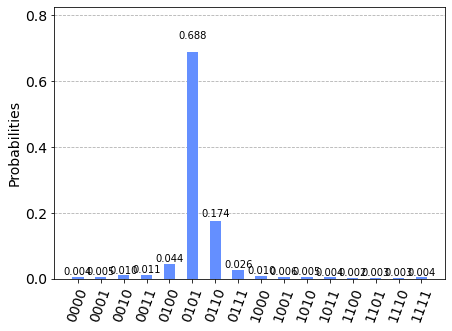

In [4]:
# Qiskit simulator
def qiskit_get_statevector(circuit):
    backend = qiskit.BasicAer.get_backend('statevector_simulator')
    job = qiskit.execute(circuit, backend)
    return job.result().get_statevector()

def qiskit_get_counts(circuit, shots=None):
    backend = qiskit.BasicAer.get_backend('qasm_simulator')
    job = qiskit.execute(circuit, backend, shots=shots)
    return job.result().get_counts()

# execute circuit
results = qiskit_get_counts(qc, shots=4096)

# classically swap qubits for QFT
# most significant bit first -> most significat bit last
# The swaps could also be done with the final measurements
# results = {state[::-1]: counts for state, counts in results.items()}

# plot results
qiskit.visualization.plot_histogram(results)

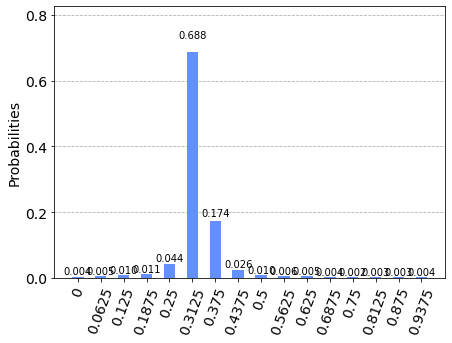

In [5]:
def frac_bin_to_decimal(bin_str):
    """
    Convert binary fractional number (str) to decimal
    Most significant bit first -- as in qiskit result output
    """
    return sum((bit == '1') and 1/(2**k) for k, bit in enumerate(bin_str, start=1))


# convert bits to value
processed_results = {frac_bin_to_decimal(state): counts for state, counts in results.items()}

qiskit.visualization.plot_histogram(processed_results)